## Download Data

In [37]:
import os
import tarfile
import urllib

"""
Downloading a CSV tarball to use for model
"""

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path) # temporarily stores tarball at tgz_path
    housing_file = tarfile.open(tgz_path)
    housing_file.extractall(path=housing_path)
    housing_file.close()
    
fetch_housing_data()

## Load in Data Structure

In [38]:
import pandas as pd

"""
Return pandas DF with housing data
"""

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Visualize Data

In [39]:
housing_data.info()
housing_data.describe()
# housing_data["ocean_proximity"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


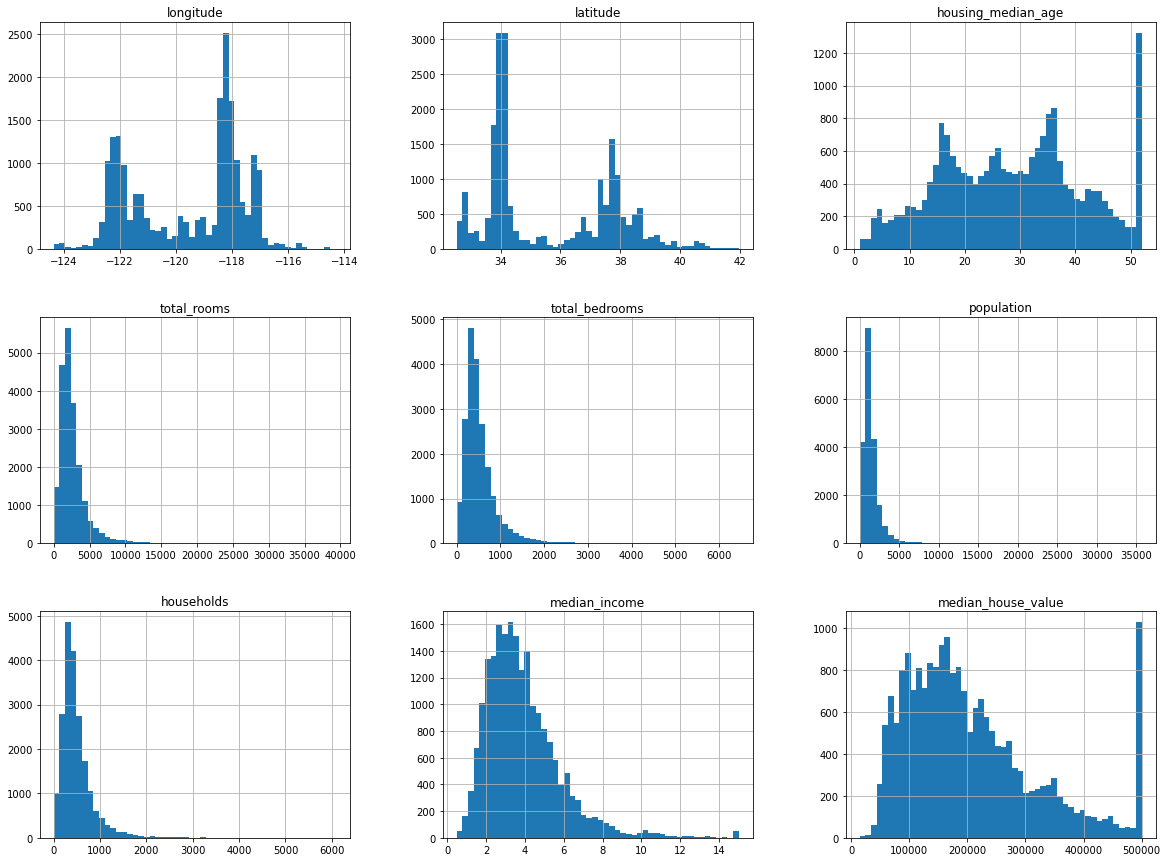

In [40]:
# Need to specify graphical backend for matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

"""
Visualize data in order to figure out what 
"""

housing_data.hist(bins=50, figsize=(20, 15))
plt.show()

Income is a very important attribute for this model. We need to examine this more closely and see the distribution of districts in different income categories

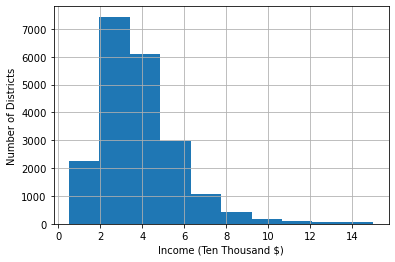

In [41]:
housing_data["median_income"].hist(bins=10)
plt.xlabel("Income (Ten Thousand $)")
plt.ylabel("Number of Districts")
plt.show()

The tail end of the income distribution may leave too few data points for meaningful use. We should condense our bins so each strata has enough data

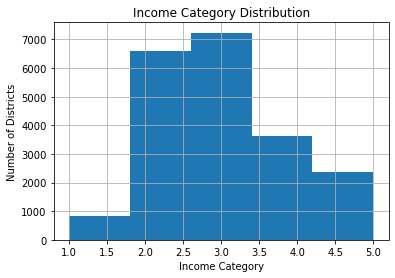

In [42]:
import numpy as np
# Each Category Represents $15,000 in income. Cat1 = $0 - 15,000, Cat2 = $15,000 - 30,000, etc.
# Cat5 is $60,000 and up, since there are not a ton of data points past that

housing_data["income_category"] = pd.cut(housing_data["median_income"], 
                                         bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                         labels=[1, 2, 3, 4, 5])

housing_data["income_category"].hist(bins=5)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.title("Income Category Distribution")
plt.show()

Now that we know the distribution of incomes, we want to take a stratified random sample using this distribution to use as our testing data.

## Stratified Testing Data Split

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

"""
Link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html 

We only need to iterate once, n=1
Use 20% of data for test split, test_size=0.2
Select a random state so our split is the same through different runs, rnadom_state=7

.split(data, target_variable) will return the ndarray of indices to use for each set
We will use housing_data["income_category"] to stratify the testing data
"""

test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for train_idx, test_idx in test_split.split(housing_data, housing_data["income_category"]):
    stratified_training_set = housing_data.loc[train_idx]
    stratified_test_set = housing_data.loc[test_idx]

# Check that the split work with our desired distribution
print ("Test Set")
print(stratified_test_set["income_category"].value_counts() / len(stratified_test_set))

print ("\nTraining Set")
print(stratified_training_set["income_category"].value_counts() / len(stratified_training_set))

# Remove the Income Category column, since it will not actually be used for our training
# Axis = 0 is for rows, Axis = 1 is for columns
for ssets in (stratified_test_set, stratified_training_set):
    ssets.drop("income_category", axis=1, inplace=True)

# Check that everything is good
stratified_test_set.head()

Test Set
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_category, dtype: float64

Training Set
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_category, dtype: float64


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19752,-122.22,40.18,13.0,3719.0,803.0,1754.0,764.0,2.3517,88900.0,INLAND
17692,-121.81,37.29,15.0,5957.0,1037.0,3838.0,997.0,6.2907,253100.0,<1H OCEAN
1689,-122.26,38.02,5.0,3846.0,786.0,2053.0,716.0,5.0473,184800.0,NEAR BAY
8369,-118.34,33.98,47.0,2649.0,684.0,2374.0,607.0,2.3882,137700.0,<1H OCEAN
17245,-119.67,34.42,37.0,1673.0,444.0,1477.0,446.0,2.0643,246700.0,<1H OCEAN


## Explore Data 

Copy stratified training data so we can play around with it. Reminder: leave the test set alone and do not look at it!

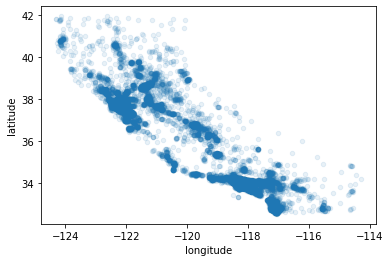

In [44]:
# LOCATION
'''
Visualize geographical location of districts using coordinates
alpha controls the opacity of each data point, which will allow us to visualize density
'''
explore_set = stratified_training_set.copy()
explore_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

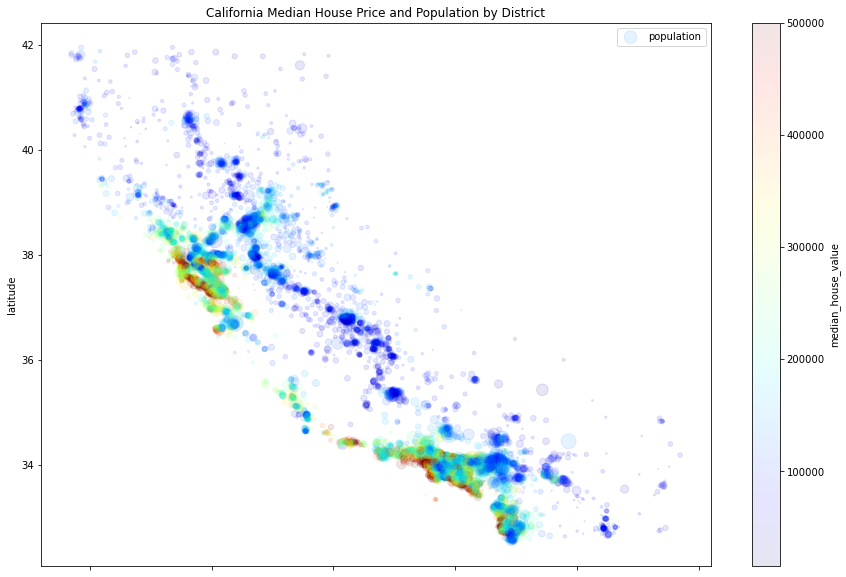

In [64]:
# PRICES AND LOCATIONS
"""
Visualize the median price of a house in each district using
coordinates and mediam house value

s = size of circle = population
c = input to colormap = median house price, use jet (predefined color map)
colorbar=True will print a legend for the colors
"""
explore_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, 
                s=explore_set["population"]/50, label="population", figsize=(15, 10),
                c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.xlabel("longitude")
plt.title("California Median House Price and Population by District")
plt.legend()
plt.show()

